Each autumn, in Catalonia, there is a big competition about [mushroom hunting](https://en.wikipedia.org/wiki/Mushroom_hunting). Unfortunately, during the past years, a lot of people have picked poisonous mushrooms thinking that they were edible, causing an overload on the healthcare system.

The Department of Health has asked to develop a model that given basic image attributes of mushrooms we can detect if it is poisonous or not, and give a guidance if which are the features most indicative of a poisonous mushroom.

# Import Data from Google Drive

In [441]:
import pandas as pd

# reading training data
url = "https://drive.google.com/file/d/19NU31GYhfb_wfKktKQ5E1YKU11eUUkrA/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path, index_col="Id")

# reading testing data
test_url = "https://drive.google.com/file/d/1wtEcWq7LLf4vb-gqn9jmDcP0vrlaoOsi/view?usp=drive_link"
test_path = 'https://drive.google.com/uc?export=download&id='+test_url.split('/')[-2]
test_data = pd.read_csv(test_path, index_col="Id")

# X and y creation
X = data.copy()
y = X.pop("poisonous")

# data splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [442]:
X_train.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
Id,,,,,,
1832,b,b,True,w,w,v
5006,f,n,True,p,g,y
4040,f,p,True,w,w,v
5533,x,g,False,w,w,a
2710,x,w,True,w,w,s


# simple model

In [443]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

X_bool = X_train.select_dtypes(include="bool").columns
X_cat = X_train.select_dtypes(include="object").columns

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), X_cat),
    ('passthrough', X_bool)
)

simple_pipe = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=5)
)
simple_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['cap.shape', 'cap.color', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['bruises'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5))])

In [444]:
from sklearn.metrics import accuracy_score

accuracy_score(
    y_true = y_train,
    y_pred = simple_pipe.predict(X_train)
)

0.9174841315637623

Is accuracy what we're reaching for here? Let's submit an entry and see what happens.

In [ ]:
test_data.assign(poisonous = simple_pipe.predict(test_data))["poisonous"].to_csv('./simple_model.csv')
files.download('./simple_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ConfusionMatrixDisplay

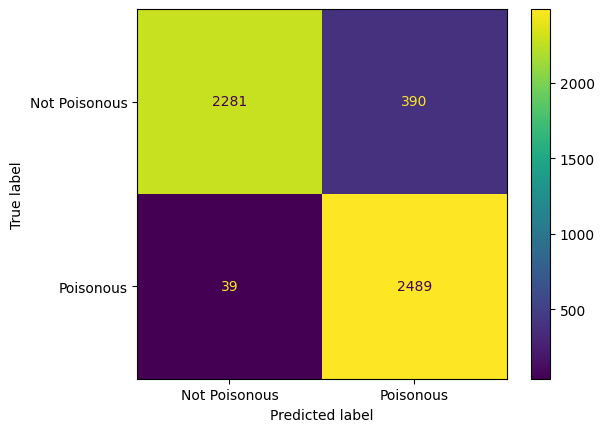

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(simple_pipe,
                                      X_train,
                                      y_train,
                                      display_labels=['Not Poisonous', 'Poisonous']);

In [ ]:
# here we can see how certain our model is when it guesses each class
simple_pipe.predict_proba(X_train)

array([[0.4380704 , 0.5619296 ],
       [1.        , 0.        ],
       [0.4380704 , 0.5619296 ],
       ...,
       [0.03288672, 0.96711328],
       [0.4380704 , 0.5619296 ],
       [0.        , 1.        ]])


- https://www.kaggle.com/getting-started/53782
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://www.youtube.com/watch?v=4jRBRDbJemM

## Random Forest

---



In [445]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [446]:
# Reading training data
url = "https://drive.google.com/file/d/19NU31GYhfb_wfKktKQ5E1YKU11eUUkrA/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path, index_col="Id")


In [447]:
# reading testing data
test_url = "https://drive.google.com/file/d/1wtEcWq7LLf4vb-gqn9jmDcP0vrlaoOsi/view?usp=drive_link"
test_path = 'https://drive.google.com/uc?export=download&id='+test_url.split('/')[-2]
test_data = pd.read_csv(test_path, index_col="Id")


In [ ]:
# X and y creation
X = data.copy()
y = X.pop("poisonous")


In [ ]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# random_state=123


In [484]:
# Preprocessing: OneHotEncoder for categorical variables and passthrough for boolean variables
X_bool = X_train.select_dtypes(include="bool").columns
X_cat = X_train.select_dtypes(include="object").columns


In [485]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), X_cat),
    ('passthrough', X_bool)
)


In [486]:
# Random Forest Classifier within a pipeline
rf_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=1000, random_state=42)
)
#Douglas Adams' "The Hitchhiker's Guide to the Galaxy,"
#where 42 is "the Answer to the Ultimate Question of Life, the Universe, and Everything."


rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['cap.shape', 'cap.color', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['bruises'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000, random_state=42))])

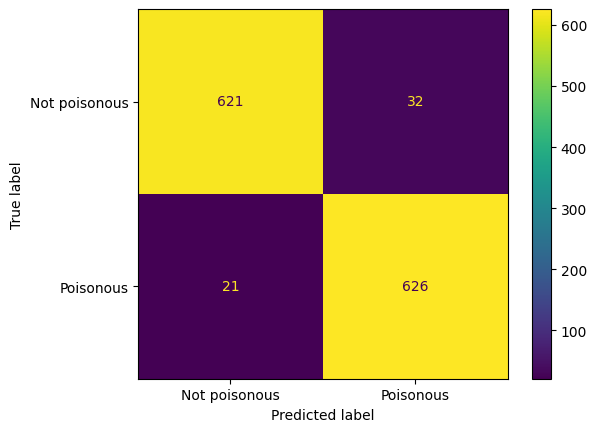

In [ ]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    rf_pipe, X_test, y_test, display_labels=['Not poisonous', 'Poisonous']);

In [ ]:
# Predictions for validation set
rf_pipeline= rf_pipe.predict_proba(X_test)
rf_pipeline = pd.DataFrame(rf_pipeline, columns=["non-poisonous", "poisonous"])
rf_pipeline

,non-poisonous,poisonous
0,0.000000,1.000000
1,1.000000,0.000000
2,0.000000,1.000000
3,1.000000,0.000000
4,0.000000,1.000000
...,...,...
1295,1.000000,0.000000
1296,0.000000,1.000000
1297,0.000000,1.000000
1298,1.000000,0.000000


In [ ]:
rf_pipeline = rf_pipeline["poisonous"]


In [ ]:
from sklearn.metrics import roc_curve

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_pipeline)

The ROC curve is plotted based on the same simulated data. In practice, the curve illustrates the performance of the classification model at all classification thresholds, with the True Positive Rate (TPR) plotted against the False Positive Rate (FPR).

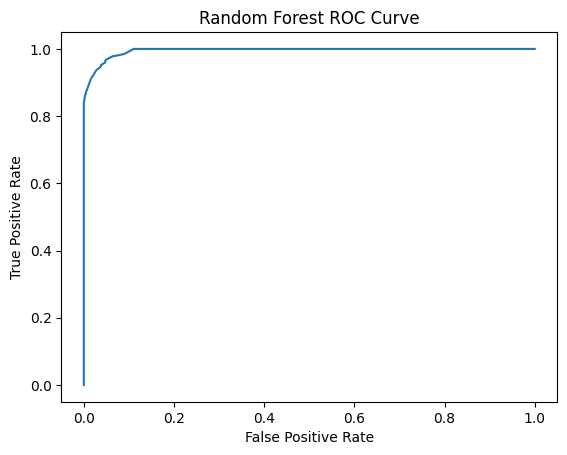

In [ ]:
# ROC Curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pipeline)
RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr).plot()
plt.title('Random Forest ROC Curve')
plt.show()

In [ ]:
#test_data.assign(poisonous = rf_pipe.predict(test_data))["poisonous"].to_csv('./random_forest_model.csv')
#files.download('./random_forest_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

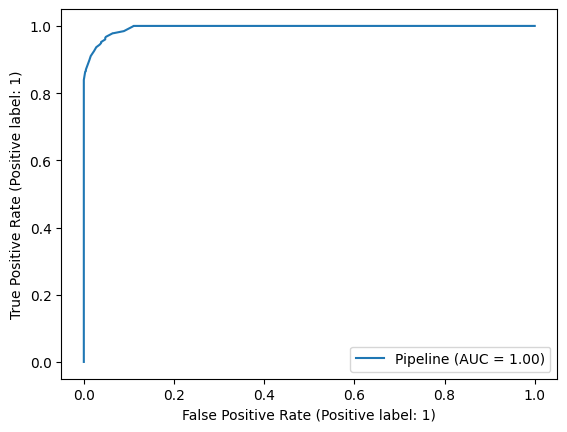

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test);

In [ ]:
win_threshold = pd.DataFrame({'fpr':rf_fpr,'tpr':rf_tpr,'threshold':rf_threshold})
win_threshold

,fpr,tpr,threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.812983,1.000000
2,0.000000,0.817620,0.999410
3,0.000000,0.823802,0.944850
4,0.000000,0.837713,0.943132
5,0.000000,0.839258,0.943011
6,0.003063,0.863988,0.915335
7,0.004594,0.865533,0.900063
8,0.004594,0.870170,0.897583
9,0.012251,0.897991,0.773783


In [ ]:
win_threshold.loc[34]

fpr          0.148545
tpr          1.000000
threshold    0.000812
Name: 34, dtype: float64

In [ ]:
win_threshold_value= win_threshold.threshold[34]
win_threshold_value

0.0008125

In [ ]:
win_threshold[win_threshold.tpr==1].sort_values("threshold", ascending=False).head(23)

,fpr,tpr,threshold
23,0.110260,1.0,0.141938
24,0.111792,1.0,0.061706
25,0.114855,1.0,0.028782
26,0.119449,1.0,0.020659
27,0.125574,1.0,0.011000
28,0.131700,1.0,0.005726
29,0.134763,1.0,0.005000
30,0.139357,1.0,0.002707
31,0.142420,1.0,0.002000
32,0.143951,1.0,0.001897


In [ ]:
rf_pipeline.sample(20)

371     1.000000
656     1.000000
4       1.000000
199     1.000000
1120    0.000000
908     0.000000
1264    1.000000
628     0.000000
386     1.000000
617     0.000000
1162    1.000000
913     0.000000
157     1.000000
990     0.000000
172     1.000000
1063    1.000000
92      1.000000
1284    0.000000
478     0.635644
1287    1.000000
Name: poisonous, dtype: float64

In [ ]:
predicted_proba = pd.DataFrame(rf_pipe.predict_proba(X_test), columns=["non-poisonous", "poisonous"])
predicted_proba.sample(25)
predicted = (predicted_proba["poisonous"] >= win_threshold_value).astype('int')


In [ ]:
## Confusion Matrix of adjusted data
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predicted)

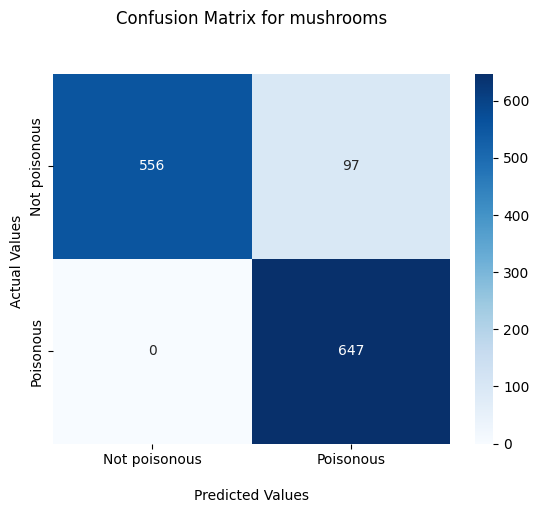

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix for mushrooms\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not poisonous','Poisonous'])
ax.yaxis.set_ticklabels(['Not poisonous','Poisonous'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
### Adjusting the predictions based on threshold value - test

predicted_proba_test = pd.DataFrame(rf_pipe.predict_proba(test_data), columns=["non-poisonous", "poisonous"])
predicted_proba_test.index = test_data.index
test_data.assign(poisonous = (predicted_proba_test["poisonous"] >= win_threshold_value).astype('int'))

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,poisonous
Id,,,,,,,
5165,f,w,True,w,w,v,1
4281,f,g,False,n,p,v,1
231,x,n,True,w,p,v,0
3890,f,n,False,w,w,s,0
1521,x,y,False,n,p,v,1
...,...,...,...,...,...,...,...
983,x,n,False,w,y,v,1
7055,x,e,True,p,g,v,0
7456,x,y,False,b,n,y,1


In [ ]:
(test_data
    .assign(poisonous = (predicted_proba_test["poisonous"] >= win_threshold_value)
        .astype('int')
        )
    ["poisonous"]
    .to_csv('./rf_threshold.csv')
)

from google.colab import files
files.download('./rf_threshold.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Re-analyze adding other Statistics Parameters

In [448]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


In [511]:
# Reading training data
url = "https://drive.google.com/file/d/19NU31GYhfb_wfKktKQ5E1YKU11eUUkrA/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
data = pd.read_csv(path, index_col="Id")

# Reading testing data
test_url = "https://drive.google.com/file/d/1wtEcWq7LLf4vb-gqn9jmDcP0vrlaoOsi/view?usp=drive_link"
test_path = 'https://drive.google.com/uc?export=download&id=' + test_url.split('/')[-2]
test_data = pd.read_csv(test_path, index_col="Id")

# X and y creation
#X = pd.get_dummies(data.drop("poisonous", axis=1))
#y = data["poisonous"]
# X and y creation
X = data.copy()
y = X.pop("poisonous")


In [482]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [512]:
# Preprocessing: OneHotEncoder for categorical variables and passthrough for boolean variables
X_bool = X_train.select_dtypes(include="bool").columns
X_cat = X_train.select_dtypes(include="object").columns


In [513]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), X_cat),
    ('passthrough', X_bool)
)

# Random Forest Classifier within a pipeline
rf_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=1000, random_state=42)
)
#Douglas Adams' "The Hitchhiker's Guide to the Galaxy,"
#where 42 is "the Answer to the Ultimate Question of Life, the Universe, and Everything."


rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['cap.shape', 'cap.color', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['bruises'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000, random_state=42))])

In [514]:
# Predicting and Evaluating on the Test Set
y_pred = rf_pipe.predict(X_test)
y_pred_proba = rf_pipe.predict_proba(X_test)[:, 1]


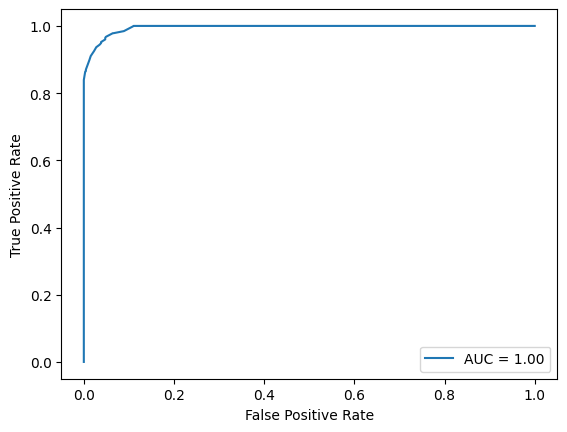

In [515]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()


In [516]:
# Threshold Tuning for Minimizing False Negatives
min_false_negatives = float('inf')
optimal_threshold = 0.5

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    # Calculate false negatives
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adjusted).ravel()

    if fn < min_false_negatives:
        min_false_negatives = fn
        optimal_threshold = threshold

print("Optimal Threshold for Minimizing False Negatives:", optimal_threshold)

Optimal Threshold for Minimizing False Negatives: 0.1419379259629262


    Youden's J focuses on maximizing the true positive rate while minimizing the false positive rate.
    G-Mean emphasizes equal performance on both classes, particularly beneficial in imbalanced datasets.
    F1 Score seeks a balance between precision and recall, useful when both false positives and false negatives are important.

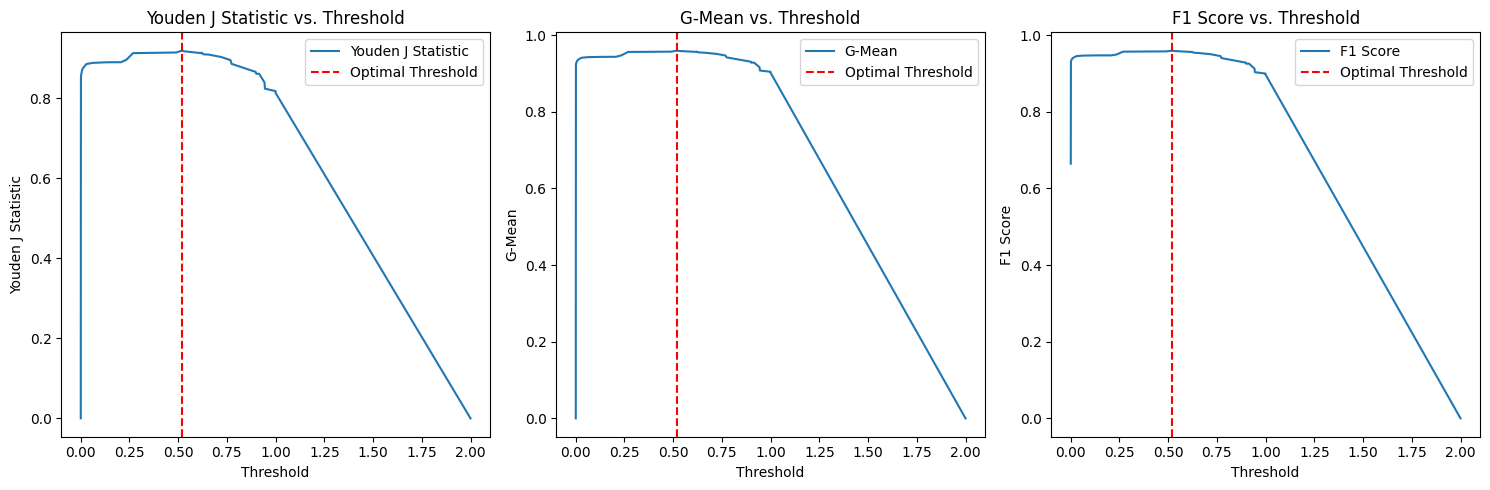

In [517]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
# Calculate additional metrics for different thresholds
#Youden's J Statistic
#G-Mean
#F1 Score

youden_j = []
g_means = []
f1_scores = []

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adjusted).ravel()

    # Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Youden's J statistic
    youden_j.append(sensitivity - (1 - specificity))

    # G-Mean
    g_means.append((sensitivity * specificity) ** 0.5)

    # F1 Score
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# Find the optimal thresholds
optimal_youden_threshold = thresholds[np.argmax(youden_j)]
optimal_gmean_threshold = thresholds[np.argmax(g_means)]
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(15, 5))

# Youden's J Statistic
plt.subplot(1, 3, 1)
plt.plot(thresholds, youden_j, label='Youden J Statistic')
plt.axvline(optimal_youden_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Youden J Statistic')
plt.title('Youden J Statistic vs. Threshold')
plt.legend()

# G-Mean
plt.subplot(1, 3, 2)
plt.plot(thresholds, g_means, label='G-Mean')
plt.axvline(optimal_gmean_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('G-Mean')
plt.title('G-Mean vs. Threshold')
plt.legend()

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_f1_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix with Optimal Threshold')

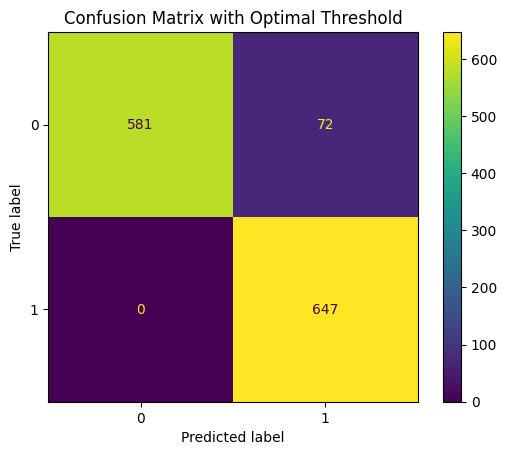

In [518]:
# Apply the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
ConfusionMatrixDisplay(conf_matrix_optimal).plot()
plt.title("Confusion Matrix with Optimal Threshold")


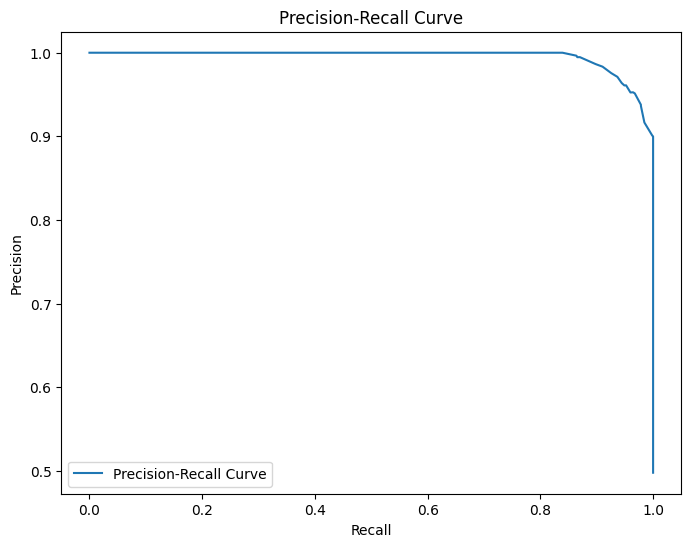

In [519]:
# Precision-Recall Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


